<a href="https://colab.research.google.com/github/theresiasns/capstone/blob/main/Disease_Crop_Detection_tflite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!ppip install --upgrade tensorflow

/bin/bash: ppip: command not found


In [2]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 488.6/488.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 47.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 441.0/441.0 kB 33.8 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.3.3
    Uninstalling flatbuffers-23.3.3:
      Successfully uninstalled flatbuffers-23.3.3


In [ ]:
import numpy as np
import os, glob
import seaborn as sns
import pandas as pd
import pickle
import cv2
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import Callback,EarlyStopping
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from sklearn.metrics import  classification_report
from keras.models import Sequential

AssertionError: ignored

In [3]:
from google.colab import drive
import os

drive.mount("/content/drive/")

Mounted at /content/drive/


In [4]:
file_path = '/content/drive/MyDrive/crop'

In [ ]:
name_class = os.listdir(file_path)
name_class

['Cherry_(including_sour)___Powdery_mildew',
 'Corn_(maize)___Common_rust_',
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Apple___Apple_scab',
 'Cherry_(including_sour)___healthy',
 'Corn_(maize)___healthy',
 'Grape___Black_rot',
 'Grape___healthy',
 'Peach___healthy',
 'Corn_(maize)___Northern_Leaf_Blight',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Peach___Bacterial_spot',
 'Grape___Esca_(Black_Measles)',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Squash___Powdery_mildew',
 'Tomato_Early_blight',
 'Tomato_Bacterial_spot',
 'Potato___Late_blight',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato_healthy',
 'Tomato_Late_blight',
 'Tomato__Target_Spot',
 'Tomato__Tomato_mosaic_virus',
 'Potato___healthy',
 'Potato___Early_blight',
 'Pepper__bell___healthy',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Pepper__bell___Bacterial_spot',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Leaf_Mol

In [ ]:
filepaths = list(glob.glob(file_path+'/**/*.*'))

In [ ]:
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))
filepath = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([filepath, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
train, test = train_test_split(data, test_size=0.25, random_state=42)

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                  validation_split=0.2)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [ ]:
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_gen = train_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False,
    seed=42
)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='Filepath',
    y_col='Label',
    target_size=(100,100),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 25395 validated image filenames belonging to 30 classes.
Found 25395 validated image filenames belonging to 30 classes.
Found 8465 validated image filenames belonging to 30 classes.


In [ ]:
pretrained_model = ResNet50(
    input_shape=(100,100, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

pretrained_model.trainable = False

94765736/94765736 [==============================] - 1s 0us/step


In [ ]:
inputs = pretrained_model.input

x = Dense(256, activation='relu')(pretrained_model.output)
x = Dense(128, activation='relu')(x)

outputs = Dense(30, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
callbacks  = [EarlyStopping(monitor='val_accuracy',
                              min_delta=0,
                              patience=2,
                              mode='auto')]

In [ ]:
history = model.fit(
    train_gen,
    validation_data=valid_gen,
    epochs=5,
    callbacks=callbacks
)

Epoch 1/5
794/794 [==============================] - 6851s 9s/step - loss: 0.6611 - accuracy: 0.7849 - val_loss: 0.3498 - val_accuracy: 0.8781
Epoch 2/5
794/794 [==============================] - 2644s 3s/step - loss: 0.3142 - accuracy: 0.8898 - val_loss: 0.1983 - val_accuracy: 0.9301
Epoch 3/5
794/794 [==============================] - 2642s 3s/step - loss: 0.2169 - accuracy: 0.9237 - val_loss: 0.1553 - val_accuracy: 0.9445
Epoch 4/5
794/794 [==============================] - 2654s 3s/step - loss: 0.1715 - accuracy: 0.9407 - val_loss: 0.1115 - val_accuracy: 0.9624
Epoch 5/5
794/794 [==============================] - 2639s 3s/step - loss: 0.1367 - accuracy: 0.9517 - val_loss: 0.1345 - val_accuracy: 0.9536


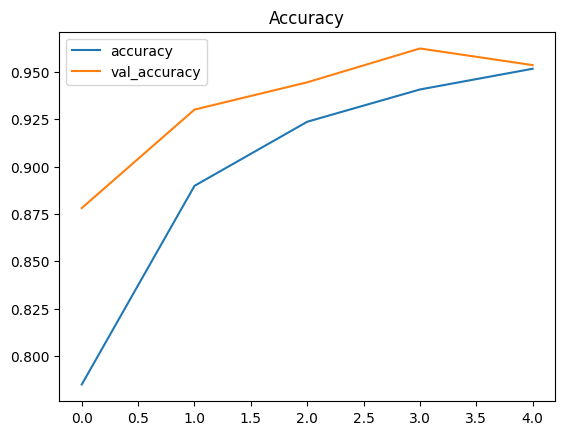

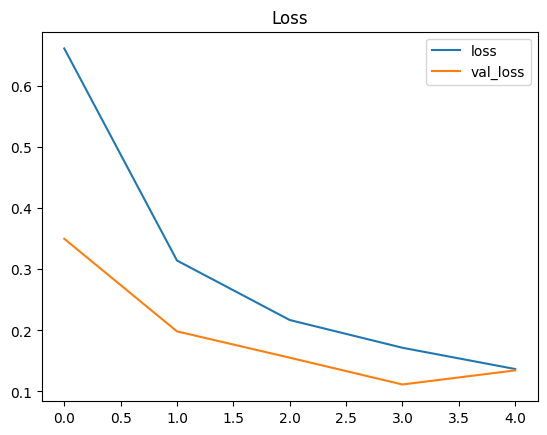

In [ ]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [ ]:
accuracy = model.evaluate(test_gen, verbose=0)

print("Accuracy: {:.2f}%".format(accuracy[1] * 100))

In [ ]:
import os
model.save_weights("/content/drive/MyDrive/crop/models1_weights.h5")
model.save("/content/drive/MyDrive/crop/models1_saved.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3052: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [5]:
export = '/content/drive/MyDrive/crop'

In [6]:
import tensorflow as tf

# Select mode of optimization
mode = "Storage" 

if mode == 'Storage':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_SIZE
elif mode == 'Speed':
    optimization = tf.lite.Optimize.OPTIMIZE_FOR_LATENCY
else:
    optimization = tf.lite.Optimize.DEFAULT

In [7]:
converter = tf.lite.TFLiteConverter.from_saved_model(export)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
tflite_model = converter.convert();


In [8]:
import pathlib

tflite_model_file = pathlib.Path('./model.tflite')
tflite_model_file.write_bytes(tflite_model)

48135968

In [ ]:
# Predict the label of the test_gen
pred = model.predict(test_gen)
pred = np.argmax(pred,axis=1)
labels = (train_gen.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

In [ ]:
y_test = list(test.Label)


In [ ]:
fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test.Filepath.iloc[i]))
    ax.set_title(f"True: {test.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()